# MARKET BASKET ANALYSIS

# Implemenatation in Python

While it is possible to use Ms Excel to calculate support, confidence and lifts, doing so on a large dataset with thousands of different combination of items can be a daunting task. Therefore, we will be resorting to Python libraries for a ready-made algorithm. Unfortunately, the popular scikit-learn library does not support this algorithm. Fortunately, we can use another library called MLxtend (machine learning extensions) by Sebastian Raschka which has an implementation of the Apriori algorithm for extracting frequent item sets for further analysis. Chris Moffitt has an awesome tutorial on using MLxtend which this project draws on.

If you are using Jupyter Notebook, the MLxtend library does not come pre-installed with Anaconda, but you can easily install this package with conda, just run one of the following in your Anaconda Prompt:

conda install -c conda-forge mlxtend<br/>
conda install -c conda-forge/label/gcc7 mlxtend


### Import Libraries

In [1]:
# import the required libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Load Data

In [2]:
# Load the data into a pandas dataframe and take a look at the first 10 rows
bread = pd.read_csv(r"C:\Users\sxh210008\Desktop\BreadBasket_DMS.csv",sep=',')
bread.head(10)

,Date,Time,Transaction,Item
0,10/30/2016,9:58:11,1,Bread
1,10/30/2016,10:05:34,2,Scandinavian
2,10/30/2016,10:05:34,2,Scandinavian
3,10/30/2016,10:07:57,3,Hot chocolate
4,10/30/2016,10:07:57,3,Jam
5,10/30/2016,10:07:57,3,Cookies
6,10/30/2016,10:08:41,4,Muffin
7,10/30/2016,10:13:03,5,Coffee
8,10/30/2016,10:13:03,5,Pastry
9,10/30/2016,10:13:03,5,Bread


In [3]:
# check the summary info of the dataframe
bread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


There are 21293 rows and  4 columns in the dataframe.Date and time are encoded in 'object' instead of datetime, but fortunately there is a Transaction column which helps to identify transaction. Item column contains the inidividual items in that transaction. For example, Transaction No.3 contains items of "Hot Choclate","Jam" and "Cookies" which are all transacted in the same time 10:07:57 on 10-30-2016  

## Check for missing values


In [4]:
# Check for missing values
bread.isnull().sum()

Date           0
Time           0
Transaction    0
Item           0
dtype: int64

In [5]:
missing_value = ["NaN","NONE", "None", "Nil", "nan", "none", "nil", 0]
print("There are {0} missing values in the dataframe.".format(len(bread[bread.Item.isin(missing_value)])))
bread[bread.Item.isin(missing_value)].head(10)

There are 786 missing values in the dataframe.


,Date,Time,Transaction,Item
26,10/30/2016,10:27:21,11,NONE
38,10/30/2016,10:34:36,15,NONE
39,10/30/2016,10:34:36,15,NONE
66,10/30/2016,11:05:30,29,NONE
80,10/30/2016,11:37:10,37,NONE
85,10/30/2016,11:55:51,40,NONE
126,10/30/2016,13:02:04,59,NONE
140,10/30/2016,13:37:25,65,NONE
149,10/30/2016,13:46:48,67,NONE
167,10/30/2016,14:32:26,75,NONE


While there is no empty cell in the dataframe, a check using the popular missing value sohws that there are 786 rows with "NONE" in the coliumn Item. Since the items are not recorded, we will have to remove these rows.

In [6]:
bread = bread.drop(bread[bread.Item == "NONE"].index)
print("Number of rows: {0}".format(len(bread)))
bread.head(10)

Number of rows: 20507


,Date,Time,Transaction,Item
0,10/30/2016,9:58:11,1,Bread
1,10/30/2016,10:05:34,2,Scandinavian
2,10/30/2016,10:05:34,2,Scandinavian
3,10/30/2016,10:07:57,3,Hot chocolate
4,10/30/2016,10:07:57,3,Jam
5,10/30/2016,10:07:57,3,Cookies
6,10/30/2016,10:08:41,4,Muffin
7,10/30/2016,10:13:03,5,Coffee
8,10/30/2016,10:13:03,5,Pastry
9,10/30/2016,10:13:03,5,Bread


After removing the missing values the numver of rows is 20507. The original no. of rows 21293 minus 786 missing. 

### Convert To DatetimeIndex


In [7]:
bread['Datetime'] = pd.to_datetime(bread['Date'] +' ' + bread['Time'])
bread = bread[["Datetime","Transaction","Item"]].set_index("Datetime")

In [9]:
bread.head(10)

,Transaction,Item
Datetime,,
2016-10-30 09:58:11,1,Bread
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:07:57,3,Hot chocolate
2016-10-30 10:07:57,3,Jam
2016-10-30 10:07:57,3,Cookies
2016-10-30 10:08:41,4,Muffin
2016-10-30 10:13:03,5,Coffee
2016-10-30 10:13:03,5,Pastry


### Quick Stats

In [16]:
total_items = len(bread)
total_days = len(np.unique(bread.index.date))
total_months= len(np.unique(bread.index.month))
average_items =total_items/ total_days
unique_items = bread.Item.unique().size

print("There are {} unique sold by the bakery".format(unique_items))
print("There are {} items sold in the {} days throughout {} months".format(total_items, total_days, total_months))
print("With an average of {} items sold daily".format(average_items))

There are 94 unique sold by the bakery
There are 20507 items sold in the 159 days throughout 7 months
With an average of 128.9748427672956 items sold daily


Note: We have combined the Date and Time columns into a single Datetime column, convert it into datetime64 type and then set it as DatetimeIndex. This will make it easier to plot the time series charts later on. Quick look at the data shows that the bakery sold an average of 129 items daily.


### Visualization 

[Text(0.5, 0, 'Item'), Text(0, 0.5, 'Percentage')]

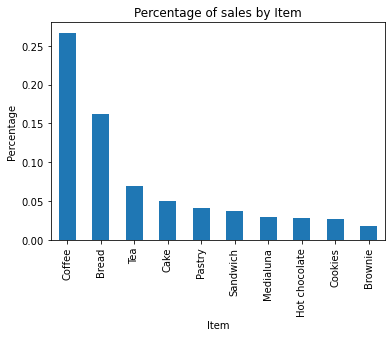

In [19]:
# Rank the top 10 best selling items
bread.Item.value_counts(normalize=True)[:10].plot(kind="bar", title="Percentage of sales by Item").set(xlabel="Item", ylabel="Percentage")


[Text(0.5, 0, 'Item'), Text(0, 0.5, 'Total Number')]

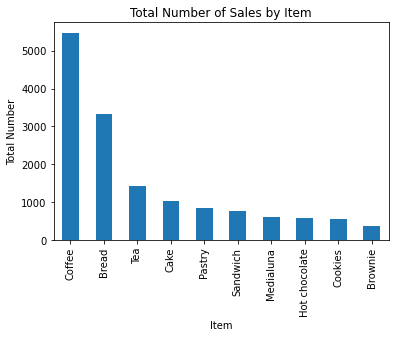

In [21]:
#create a bar chart, rank by value 
bread.Item.value_counts()[:10].plot(kind="bar",title="Total Number of Sales by Item").set(xlabel="Item", ylabel="Total Number")

Note: From the chart above it's clear that Coffee(26.7%) is the best-selling item in the bakery, follow by Bread(16.2%) and Tea(7.0%)

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total Number of Items sold')]

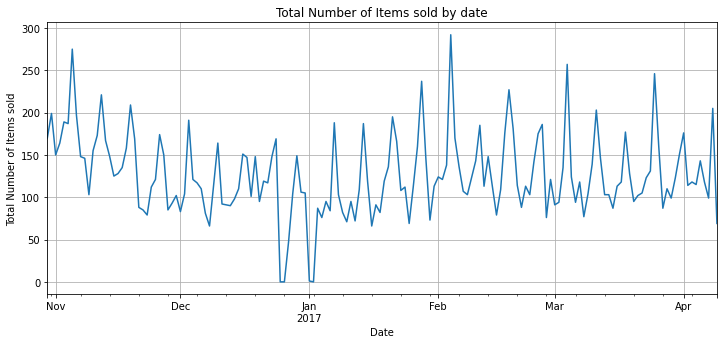

In [24]:
# plot the series chart of number of items by day
bread["Item"].resample("D").count().plot(figsize=(12,5), grid=True, title="Total Number of Items sold by date").set(xlabel="Date", ylabel="Total Number of Items sold")

Note : Total NUmber of Items sold by data fluctuates a lot throughout the 159 days of data.

In [25]:
bread["Item"].resample("M").count()

Datetime
2016-10-31     369
2016-11-30    4436
2016-12-31    3339
2017-01-31    3356
2017-02-28    3906
2017-03-31    3944
2017-04-30    1157
Freq: M, Name: Item, dtype: int64

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Total number of items sold')]

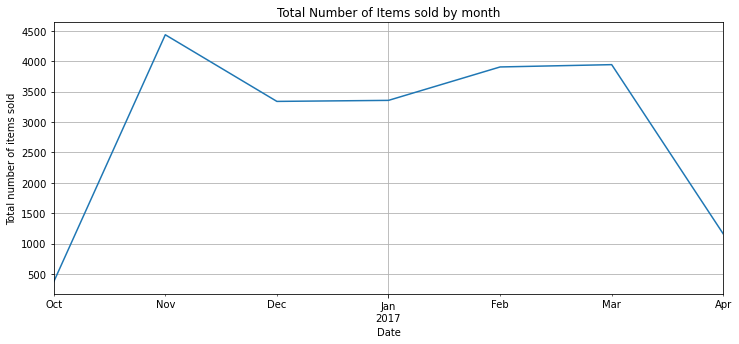

In [26]:
# plot the time series chart of number of items by month.
bread["Item"].resample("M").count().plot (figsize=(12,5), grid=True, title="Total Number of Items sold by month").set(xlabel="Date",ylabel="Total number of items sold")

Note: Given the beginning month(october 2016) and ending month(April 2017) are not full month, the total number of items sold by month for the five full month betweeen November 2016 and March 2017 does not fluctuate too much.
    

In [28]:
# extract hour of the day and weekday of the week
# For Datetimeindex, the dayof the week with Monday=0, Sunday=6, thereby +1 to become Monday=1, Sunday= 7
bread["Hour"] = bread.index.hour
bread["Weekday"] = bread.index.weekday + 1

bread.head(10)

,Transaction,Item,Hour,Weekday
Datetime,,,,
2016-10-30 09:58:11,1,Bread,9,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:07:57,3,Hot chocolate,10,7
2016-10-30 10:07:57,3,Jam,10,7
2016-10-30 10:07:57,3,Cookies,10,7
2016-10-30 10:08:41,4,Muffin,10,7
2016-10-30 10:13:03,5,Coffee,10,7
2016-10-30 10:13:03,5,Pastry,10,7


In [29]:
bread_groupby_hour = bread.groupby("Hour").agg({"Item": lambda item: item.count()/total_days})
bread_groupby_hour

,Item
Hour,
1,0.006289
7,0.150943
8,4.056604
9,12.364780
10,16.767296
11,19.509434
12,17.949686
13,16.459119
14,16.603774


[Text(0.5, 0, 'Hour of the day(24 hour time)')]

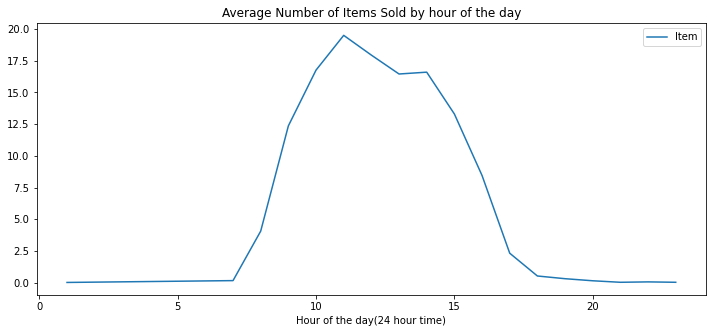

In [30]:
# plot the chart
bread_groupby_hour.plot(y="Item", figsize=(12,5), title="Average Number of Items Sold by hour of the day").set(xlabel="Hour of the day(24 hour time)")

Note:Sales to pick up from 8am, till the busiest hour of the day at 11am , then slowly drops till the late afternoon. It can be observed thatmost of the sales transactions take place during the lunch hours of the day.

In [32]:
# sales grouopby weekday
bread_groupby_weekday = bread.groupby("Weekday").agg({"Item": lambda item: item.count()})
bread_groupby_weekday

,Item
Weekday,
1,2324
2,2392
3,2321
4,2646
5,3124
6,4605
7,3095


In [34]:
# but we need t ofind out how many each weekdayin that period of transaction
# in order to calculate the average items per weeekday

import datetime
daterange = pd.date_range(datetime.date(2016,10,30), datetime.date(2017,4,9))

monday=0
tuesday=0
wednesday=0
thursday=0
friday=0
saturday=0
sunday=0

for day in np.unique(bread.index.date):
    if day.isoweekday() == 1:
        monday +=1
    elif day.isoweekday() == 2:
        tuesday +=1
    elif day.isoweekday() == 3:
        wednesday +=1
    elif day.isoweekday() == 4:
        thursday +=1
    elif day.isoweekday() == 5:
        friday +=1
    elif day.isoweekday() == 6:
        saturday +=1
    elif day.isoweekday() == 7:
        sunday +=1
        
all_weekdays = monday + tuesday + wednesday + thursday + friday + saturday + sunday

print("monday = {0}, tuesday = {1}, wednesday = {2}, thursday = {3}, friday = {4}, saturday = {5}, sunday = {6}, total = {7}".format(monday,tuesday,wednesday,thursday,friday,saturday,sunday,all_weekdays))

monday = 21, tuesday = 23, wednesday = 23, thursday = 23, friday = 23, saturday = 23, sunday = 23, total = 159


In [36]:
# apply the conditions to calculate the average items for each weekday
conditions = [
    (bread_groupby_weekday.index == 1),
    (bread_groupby_weekday.index == 2),
    (bread_groupby_weekday.index == 3),
    (bread_groupby_weekday.index == 4),
    (bread_groupby_weekday.index == 5),
    (bread_groupby_weekday.index == 6),
    (bread_groupby_weekday.index == 7)]

choices = [bread_groupby_weekday.Item/21,
          bread_groupby_weekday.Item/23,
          bread_groupby_weekday.Item/23,
          bread_groupby_weekday.Item/23,
          bread_groupby_weekday.Item/23,
          bread_groupby_weekday.Item/23,
          bread_groupby_weekday.Item/23]

bread_groupby_weekday["Average"] = np.select(conditions,choices, default =0)
bread_groupby_weekday

,Item,Average
Weekday,,
1,2324,110.666667
2,2392,104.000000
3,2321,100.913043
4,2646,115.043478
5,3124,135.826087
6,4605,200.217391
7,3095,134.565217


[Text(0.5, 0, 'Day of the week(1=Monday, 7=Sunday)')]

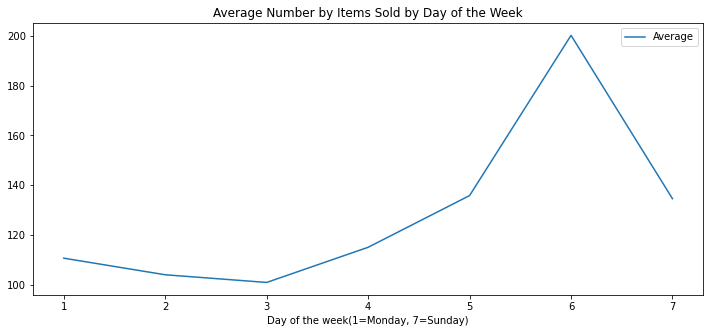

In [37]:
bread_groupby_weekday.plot(y="Average", figsize=(12,5), title="Average Number by Items Sold by Day of the Week").set(xlabel="Day of the week(1=Monday, 7=Sunday)")

Note : Saturday is the busiest day of the week with the highest sales(approx 200 items) while Wednesday is the quietest day with the lowest sales( approx 101 items). This is an intresting insight, the owner should launch some production activities to boost up sales in the middle of the week when sales are slowest. 

### One- Hot Encoding

The apripori function is the MLxtend library expects data in one-hot encoded pandas DataFrame.This means that all the data for a transaction must be included in one row and the items must bt one-encoded. 

Therefore, we'll need to group the bread dataframe by Transaction and Item and display the count of items. Then we need to consolidate the items into one transaction per row with each item one-encoded.


In [38]:
df =bread.groupby(["Transaction","Item"]).size().reset_index(name="Count")
df.head()

,Transaction,Item,Count
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1


In [39]:
basket = (df.groupby(['Transaction', 'Item'])['Count'].sum().unstack().reset_index().fillna(0).set_index('Transaction'))
basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
basket[basket.Coffee == 4].iloc[:,14:28]

Item,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes
Transaction,,,,,,,,,,,,,,
6560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0
6850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
6887,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


Note: At this stage, the one-hot encoded table shows the count of items purchased as result. If you observe the portion of the table above, in Transaction 6887, the cell value for Coffee is "4.0" because there were 4 coffee purchased in this transaction. However, this is not important for us and we need to convert this value into 1.

In [41]:
# the encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    

In [42]:
basket_sets = basket.applymap(encode_units)

basket_sets.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
basket_sets[basket_sets.Coffee == 1].iloc[3142:3145,14:28]

Item,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes
Transaction,,,,,,,,,,,,,,
6884,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6885,1,0,0,0,0,0,0,0,0,1,0,0,0,0
6887,0,1,0,0,0,0,0,0,0,1,0,0,0,0


Note: After applying the encoding function, for the same Transaction 6887, the cell value for Coffee has become "1" which is what we need for the Apriori function.

### Generate Frequent Itemsets

Now, we are ready to generate the frequent item sets. we will set the minimum-support threshold at 1%

In [46]:
frequent_itemsets =apriori(basket_sets, min_support=0.01, use_colnames=True)

### Generate Association Rules

The final step is to generate the rules with their corresponding support, confidence and lift. We will set the minimum threshold for lift at 1 and then sort the result by descending confidence value.

In [50]:
rules =association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values("confidence",ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
30,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
28,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
18,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
22,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
16,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919
24,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384
6,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
26,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366
12,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174


## Intrepretation and Implications

The output above shows the Top 10 itemsets sorted by confidence value and all itemsets have supported value over 1% and lift value over 1. The first itemset shows the association rule "if Toast then Coffee" with support value at 0.023666	means nearly 2.4% of all transactions have this combinations of Toast and coffee bought together.We also have 70% confidence that Coffee sales happen whenever a Toast is purchased.The Lift value of 1.47(greater than 1) shows that the purchase of Coffee is indeed influenced by the purchase of Toast rather than Coffee's purchase being independent of Toast. The lift value of 1.47 means that Toast's purchase lifts the coffee's purchase by 1.47 times.

Therefore, we can conlcude that there is evidence against to suggest that the purchase of Toast leads to the purchase of coffee. The owner of the bakery "The Bread Basket" should consider bundling Toast and coffee together as a Breakfast Set or Lunch Set, the staff in the store should also be trained to cross-sell Coffee to customers who purchase Toast, knowing that they are more likely to purchase them together, thereby increasing the store's revenue.

